# Random Forest Classification Algorithm

This script is made to work for data in projected coordinate system (WGS 1984 Web Mercator Auxillary Sphere)

## Necessary packages

In [1]:
from os import path as op
import pickle

import glob
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import shapely as shp
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
from osgeo import gdal
import folium

# Model
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from treeinterpreter import treeinterpreter as ti

# Visualization
import matplotlib.pyplot as plt
import warnings

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Define parameters and path
training_data_path = "Training_Data/Ghaz_sample3.shp"
raster_file_path = "Data_Preprocessed/Clip_UTM43N_Stack_m.tif"
root_dir = "RF_Results"
output_file_name = "classification_4.tif"
output_projected_name = "classified_RF_4.tif"

## Data Preparation

### Label Data
Training dataset (GeoJSON, Shapefile) already prepared by creating polygons for each land use will be used. These polygons are prepared using GIS didgitizing method (QGIS, ArcGIS, Google Earth Engine) with satellite image to trace over.

Make sure specific class names given to polygons.

In [2]:
# read in training data polygons that created as geojson from a shared directory
training_data = training_data_path
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

Class                                           geometry
0  urban  POLYGON Z ((8609706.784 3328248.954 0.000, 861...
1  urban  POLYGON Z ((8610759.214 3332127.924 0.000, 861...
2  urban  POLYGON Z ((8608737.053 3335715.968 0.000, 860...
3  urban  POLYGON Z ((8612605.449 3334114.543 0.000, 861...
4  urban  POLYGON Z ((8618196.967 3335664.805 0.000, 861...

In [3]:
training_vectors.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Class     128 non-null    object  
 1   geometry  128 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.1+ KB


### Raster data

In [4]:
# raster information
raster_file = raster_file_path

### Map Display -  Display training data and raster data


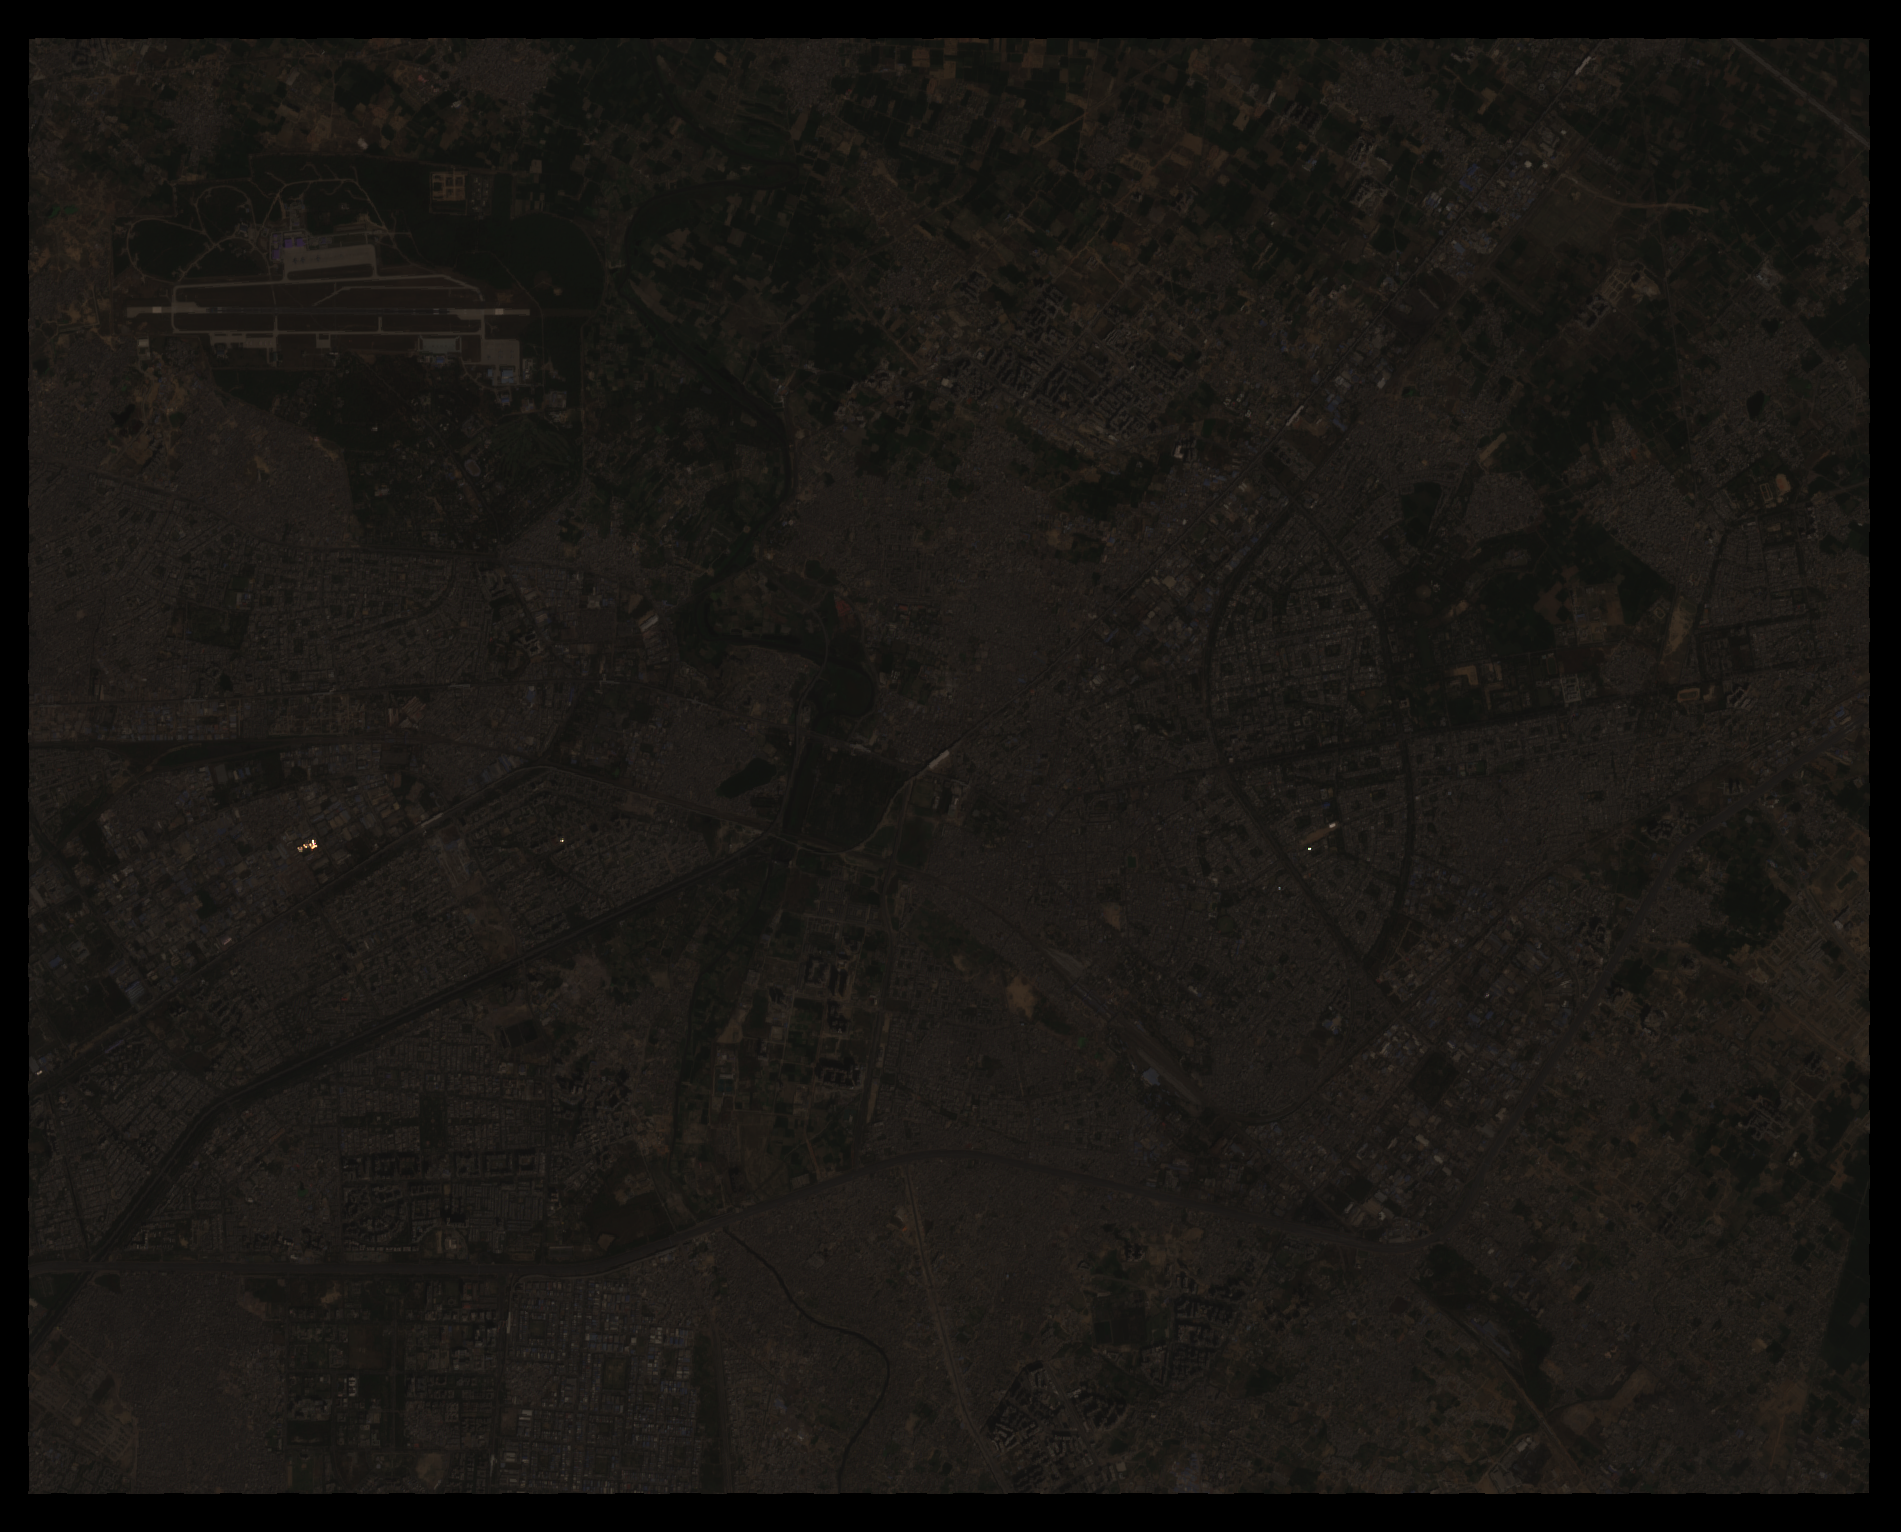

In [5]:
import rasterio as rio
import folium
from pyproj import Transformer 
import ast


## Raster
dst_crs = 'EPSG:4326'

with rio.open(raster_file) as src:
    
    img = src.read()
    img_rgb = np.stack([img[2], img[1], img[0]])
    
    if 'init' in src.crs:
        src_crs = src.crs['init'].upper()
    else:
        src_crs = 'EPSG: 3857'
        
    min_lon, min_lat, max_lon, max_lat = src.bounds
    
# Conversion from UTM to WGS84 CRS
bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]

bounds_fin = []
 
for item in bounds_orig:   
    #converting to lat/lon
    lat = item[0]
    lon = item[1]
    
    proj = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

    lon_n, lat_n = proj.transform(lon, lat)
    
    bounds_fin.append([lat_n, lon_n])

# Finding the centre latitude & longitude    
centre_lon = bounds_fin[0][1] + (bounds_fin[1][1] - bounds_fin[0][1])/2
centre_lat = bounds_fin[0][0] + (bounds_fin[1][0] - bounds_fin[0][0])/2


## Vector
map_vector = folium.features.GeoJson(training_vectors)

m = folium.Map(location=[centre_lat, centre_lon], zoom_start = 12)

# Overlay raster (RGB) called img using add_child() function (opacity and bounding box set)
m.add_child(folium.raster_layers.ImageOverlay(img_rgb.transpose(1, 2, 0), opacity=1, 
                                 bounds = bounds_fin))
m.add_child(map_vector)

# Display map 
m

## Model Training
Training a model to identify classes of land use based on training on satellite imagery

### Prepare Data
Organize the training data to correct python types and extract sample pixels from intersecting imagery.

In [6]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.Class)
classes

array(['barren', 'grass', 'shadow', 'urban', 'vegetation', 'water'],
      dtype=object)

In [7]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict   

{'barren': 0, 'grass': 1, 'shadow': 2, 'urban': 3, 'vegetation': 4, 'water': 5}

This section loops through the training classes and their polygons reading the imagery raster extracting values.

In [8]:
# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.Class, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)

        # store our window information
        window_affine = src.window_transform(window)

        # Read the data from the window
        fsrc = src.read(window=window)

        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint16',
            all_touched=True
        ).astype(bool)
        
        # Loop over each pixel in the binary mask that corresponds to the label
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]

            # Replace NaN values with 1e-3 and store the result in one_x
            one_x = np.nan_to_num(data, nan=1e-3)

            # Add the extracted pixel values to the X_raw list
            X_raw.append(one_x)
            
            # add the label to y_raw list
            y_raw.append(class_dict[label])

In [9]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((112554, 4), (112554,))

In [10]:
# importing pandas as pd  
import pandas as pd  

df = pd.DataFrame(X)
df.columns = ['B1', 'B2', 'B3', 'B4']

### Split Data
Split 20% of the data for testing the quality of the trained model.

In [21]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])

The number of records in the training dataset is 90043
The number of records in the test dataset is 22511


Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [12]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 5.810575246949448e-05,
 1: 0.00010583130489998942,
 2: 0.001072961373390558,
 3: 2.9938327046284653e-05,
 4: 3.7904631946023805e-05,
 5: 0.0003748125937031484}

## Tuning Hyperparameters
We will use RandomSearchCv to get the best parameters for random forest algorithm. This method works best for large, multi-dimensional dataset. And would take much less computational time.

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=400, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [4, 6]

# Quality of split
criterion = ['gini', 'entropy']



In [35]:
# Random forest classifier w/o class balance
rf_Model = RandomForestClassifier()

In [36]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'criterion': criterion}

print(param_grid)

{'n_estimators': [50, 88, 127, 166, 205, 244, 283, 322, 361, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [4, 6], 'criterion': ['gini', 'entropy']}


RandomizedSearchCV

In [37]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator=rf_Model, param_distributions=param_grid, cv=10, verbose=1, n_jobs=-1)

In [38]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 88, 127, 166, 205,
                                                         244, 283, 322, 361,
                                                         400]},
                   verbose=1)

In [39]:
hyperParams = rf_RandomGrid.best_params_
print(hyperParams)

{'n_estimators': 127, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'}


In [40]:
print(f'Train Accuracy : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test Accuracy : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train Accuracy : 0.896
Test Accuracy : 0.893


### Train RandomForest

In [47]:
# initialize a RandomForestClassifier
# clf = RandomForestClassifier(
#     n_estimators=100,
#     class_weight=class_weight_dict,
#     max_depth=6,
#     n_jobs=-1,
#     verbose=1,
#     random_state=0)

clf = RandomForestClassifier(**hyperParams)

In [48]:
# fit the model to the data (training)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features='auto', n_estimators=400)

In [49]:
score = clf.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.8929412287326196


In [50]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

In [51]:
# (optional) save the trained model as python pickle file
my_root_dir = root_dir
"""model_name = op.join(my_root_dir,'random_forest2.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile) """

## Assess the Model
A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

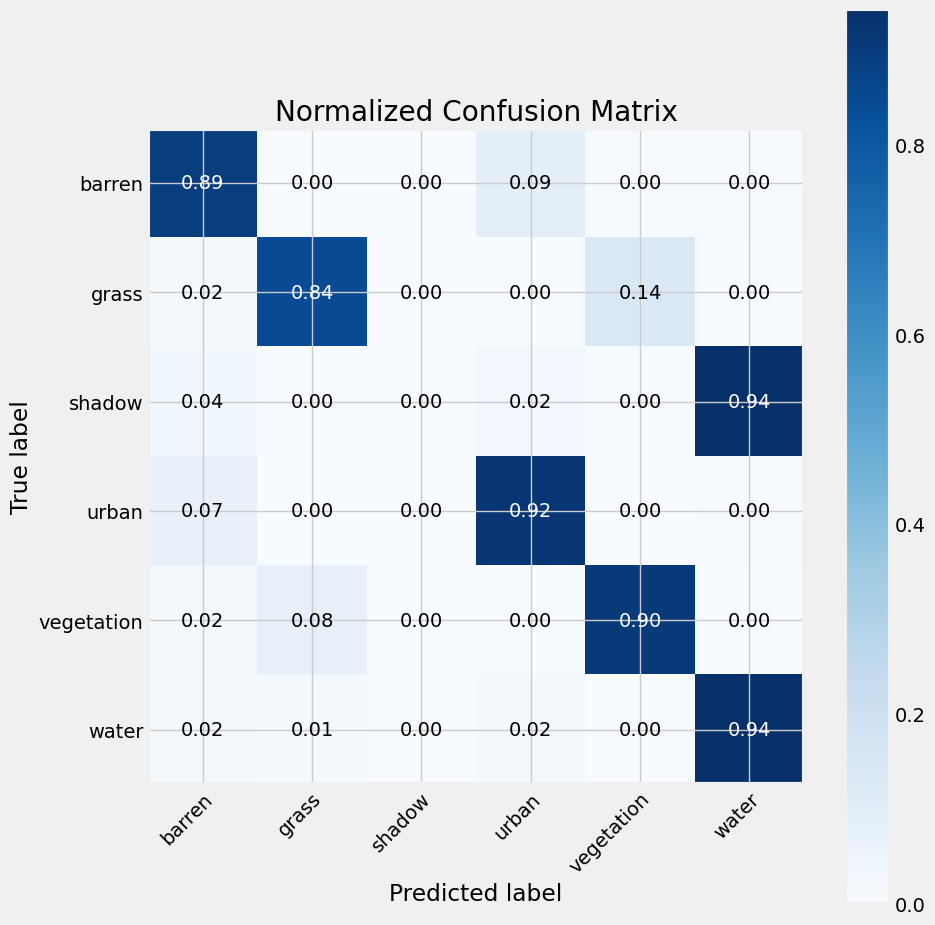

In [52]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

### Model Metrics
We can calculate accuracy of the model using the test dataset.

In [53]:
score = clf.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.8929412287326196


Producer and user accuracy

In [54]:
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
prediction_probs = clf.predict_proba(X_test)

test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4296
           1       0.79      0.84      0.81      2444
           2       0.00      0.00      0.00       220
           3       0.95      0.92      0.93      8271
           4       0.94      0.90      0.92      6576
           5       0.72      0.94      0.82       704

    accuracy                           0.89     22511
   macro avg       0.70      0.75      0.72     22511
weighted avg       0.89      0.89      0.89     22511

Test Recall
-------------------------------------------------------
0.9963692946058091
Confusion Matrix
-------------------------------------------------------
[[3842   14    0  405   18   17]
 [  44 2059    0    2  337    2]
 [   8    0    0    5    0  207]
 [ 598   29    0 7600   10   34]
 [ 132  508    0    0 5936    0]
 [  15    8    0   15    2  664]]


To see, how each band in the dataset contributes to classifictaion. We use tree interpreter which interprets decision tree and random forest predictions.

In [55]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [56]:
# plot the contributions
band_names = ['Blue', 'Green', 'Red', 'NIR']

gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
gdf.style.background_gradient(cmap='viridis')

## Classified Image

### Generate predictions over the full image
We've trained and tested the model over the existing data. We can use the trained RandomForestClassifier clf over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [59]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, output_file_name)

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint16,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                # img_ndvi = band_index(img_flat, 3, 2)
                # img_ndwi = band_index(img_flat, 1, 3)

                # img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)
                img_w_ind = img_flat
                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint16), 1, window=window)
                dst.write_mask(mask, window=window)

## Visualization - Classified and Orginal Image

<AxesSubplot:>

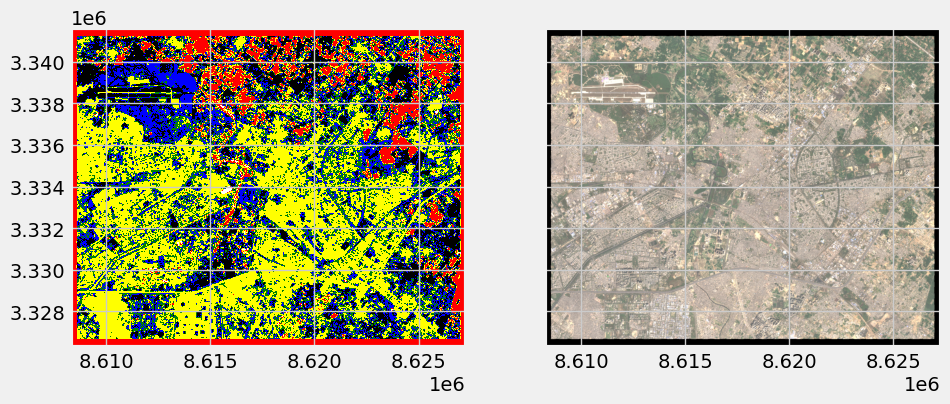

In [60]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.colors import ListedColormap
%matplotlib inline

# Load the original image
# Load the classification

output_image = root_dir + '//' + output_file_name

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint16)
  #print(s2.shape)


# Define a colormap for the classes
# colors = [(0,0,0), (0,0,1), (0,1,0), (1,1,0), (1,0,0)] # add more colors as needed
# cmap = ListedColormap(colors)

cmap = plt.cm.colors.ListedColormap(['black', 'blue', 'green', 'yellow', 'red', 'white'])


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1, cmap=cmap, )
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)


### Export - predicted raster to GeoTiff
This part of code exports the projected classified image.

In [61]:
import gdal

# Open the raster file
original_im = gdal.Open(raster_file)

# Get the raster's geotransform
geoTransform = original_im.GetGeoTransform()

# Get the raster's projection
rasterProjection = original_im.GetProjection()

# Get the width and height of the raster
width = original_im.RasterXSize
height = original_im.RasterYSize

predictedPath = root_dir + '//' + output_projected_name 
out_raster = gdal.Open(output_image)

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, width, height, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(out_raster.ReadAsArray())
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

Credits to author: Drew Bollinger, Zhuang-Fang Yi, Alex Mandel
https://drive.google.com/drive/folders/1jM2mBsJ81QfmyaKZNeXSTyi_IOVr_3Vs?usp=sharing